# Ejercicio 2

Implementar el algoritmo de perceptrón simple lineal y perceptrón simple no lineal (sin librerías). 
Utilizar ambos para aprender a clasificar los datos en el archivo “TP3-ej2-conjunto.csv”.

In [1]:
import sys; sys.path.append("..")

import pandas as pd
import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from src.perceptron_multicapa import PerceptronMulticapa, Layer
from src.optimizer import SGD, Momentum, RMSprop, AdaGrad, Adam

In [2]:
def load_dataset():
    d = np.loadtxt("../data/TP3-ej2-conjunto.csv", delimiter=",", skiprows=1)
    x = d[:, :-1]
    y = d[:, -1].reshape(-1)
    return x, y

## Capacidad de aprendizaje
Comparar la capacidad de aprendizaje del perceptrón simple lineal y del
perceptrón simple no lineal para aprender la función cuyas muestras están en
los archivos.

In [3]:
x, y = load_dataset()

In [4]:
opt = SGD()
opt.learning_rate = 0.01

perceptrones = {
    "lineal"  : PerceptronMulticapa([Layer(dims_in=3, dims_out=1, activation_function="linear")], opt),
    "nolineal": PerceptronMulticapa([Layer(dims_in=3, dims_out=1, activation_function="sigmoid")], opt)
}

history = {}
for k, p in perceptrones.items():
    history[k] = p.train(x, y, epochs=1000)

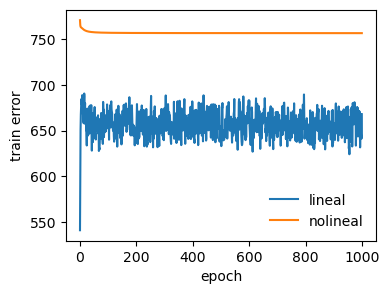

In [5]:
def plot_history(history):
    fig, ax = plt.subplots(figsize=(4,3))
    
    for k, h in history.items():
        plt.plot(
            [d["epoch"] for d in h],
            [d["train_loss"] for d in h],
            label=k
        )
    plt.ylabel("train error")
    plt.xlabel("epoch")
    plt.legend(frameon=False)
    
plot_history(history)
plt.show()

⚠️ El entrenamiento parece que no esta funcionando.

Vamos a ver un poco los valores de salida del dataset, en el mismo se observa que los valores estan por fuera del rango $0..1$ del perceptron no lineal con función de activación sigmoide, además nuestros pesos estan inicializados para trabajar dentro del entorno $0..1$.

In [6]:
pd.concat((
    pd.DataFrame(x, columns=["x1", "x2", "x3"]),
    pd.DataFrame(y, columns=["y"])
)).describe()

,x1,x2,x3,y
count,28.000000,28.000000,28.000000,28.000000
mean,0.803571,1.005714,0.980714,29.454857
std,2.731772,1.899658,1.395434,26.995155
min,-2.000000,-2.000000,-2.000000,0.320000
25%,-0.500000,0.000000,0.000000,6.348750
50%,0.000000,0.600000,1.000000,21.586000
75%,1.200000,1.850000,2.000000,49.500000
max,7.900000,7.900000,3.230000,88.184000


## Escalado del problema

En esta prueba vamos a escalar los datos de salida en el rango $0..1$.

In [7]:
x, y = load_dataset()
x_norm = 0 + (x - x.min()) * (1 - 0) / (x.max() - x.min())
y_norm = 0 + (y - y.min()) * (1 - 0) / (y.max() - y.min())

In [8]:
opt = Adam()

perceptrones = {
    "lineal"  : PerceptronMulticapa([Layer(dims_in=3, dims_out=1, activation_function="linear")], opt),
    "nolineal": PerceptronMulticapa([Layer(dims_in=3, dims_out=1, activation_function="sigmoid")], opt)
}

history = {}
for k, p in perceptrones.items():
    history[k] = p.train(x_norm, y_norm, epochs=100)

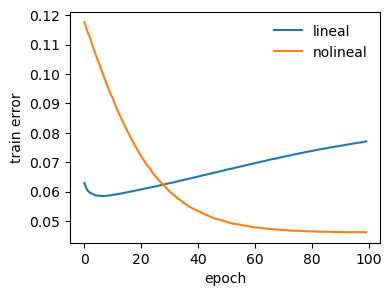

In [9]:
plot_history(history)
plt.show()

En la siguiente prueba normalizamos la entrada y la salida (a esta última la escalamos).

In [10]:
x, y = load_dataset()
x_norm = (x - x.mean()) / x.std()
y_norm = 0 + (y - y.min()) * (1 - 0) / (y.max() - y.min())

In [11]:
opt = Adam()

perceptrones = {
    "lineal"  : PerceptronMulticapa([Layer(dims_in=3, dims_out=1, activation_function="linear")], opt),
    "nolineal": PerceptronMulticapa([Layer(dims_in=3, dims_out=1, activation_function="sigmoid")], opt)
}

history = {}
for k, p in perceptrones.items():
    history[k] = p.train(x_norm, y_norm, epochs=100)

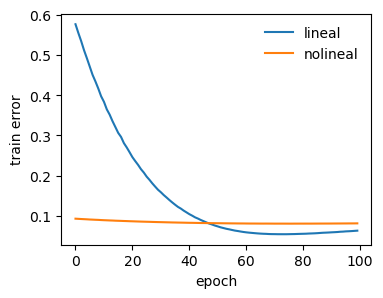

In [12]:
plot_history(history)
plt.show()

**Conclusión**
* Pre-procesar correctamente los datos de entrada es importante.
* Basura entra $\rightarrow$ Basura sale

## Capacidad de generalización
Para hacer más sencillo el proceso particionaremos la salida en cajas de acuerdo a su distribución.

Entonces nuestro problema pasa de ser una **Regresión** a una **Clasificación**

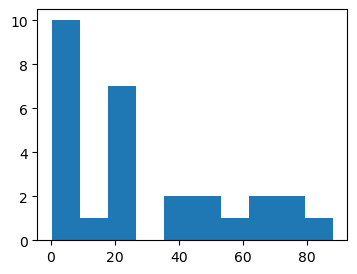

In [13]:
x, y = load_dataset()
fig, ax = plt.subplots(figsize=(4,3))
_, bins, _ = plt.hist(y, bins=10)
plt.show()

In [14]:
# Armo labels de clasificacion
y_enc = np.zeros((len(y), len(bins) - 1))
for i, y_value in enumerate(y):
    for j, lb in enumerate(bins[1:]):
        if y_value <= lb:
            y_enc[i, j] = 1
            break
            

In [15]:
def get_dataset_split(x, y, p_train):
    indices = np.arange(len(y))
    np.random.shuffle(indices)

    split = round(len(y) * p_train)
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    x_train = x[train_indices]
    y_train = y[train_indices]
    
    x_test = x[test_indices]
    y_test = y[test_indices]
    return x_train, y_train, x_test, y_test

In [16]:
perc_train = np.arange(2, 10, 1) / 10
opt = Adam()

history = []
for corr in range(10):
    for p_train in perc_train:
        x_train, y_train, x_test, y_test = get_dataset_split(x, y_enc, p_train)
        p = PerceptronMulticapa([Layer(dims_in=3, dims_out=len(bins) - 1, activation_function="sigmoid")], opt)
        h = p.train(x_train, y_train, x_test, y_test, epochs=500, batch_size=1)
        for d in h:
            d["p_train"] = p_train
            d["corrida"] = corr
        history.extend(h)

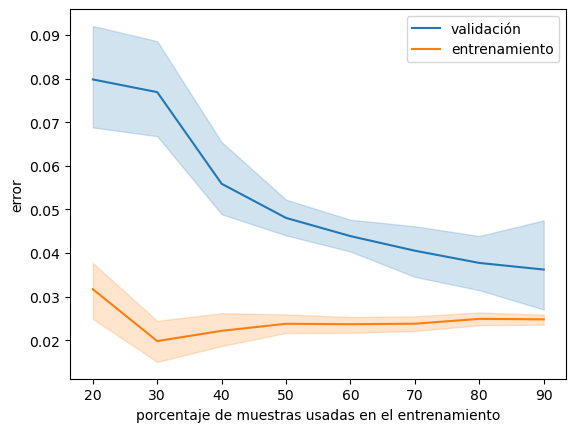

In [17]:
import seaborn as sns
df = pd.DataFrame(history)
df = df[df.epoch == df.epoch.max()]
df.p_train *= 100
sns.lineplot(data=df, x="p_train", y="val_loss", label="validación")
sns.lineplot(data=df, x="p_train", y="train_loss", label="entrenamiento")
plt.legend()
plt.ylabel("error")
plt.xlabel("porcentaje de muestras usadas en el entrenamiento")
plt.show()

### k-fold
Al particionar el dataset tenemos un mejor resultado final, ya que podemos usar de forma más efectiva los datos.
Este dataset es pequeño lo cual dejar de lado datos para el entrenamiento tiene un gran costo.

In [18]:
len(x)

28

In [19]:
split = 20
x_train = x[:split]
y_train = y_enc[:split]

x_test = x[split:]
y_test = y_enc[split:]

train_history = []
test_history = {}
opt = Adam()
for fold in [4, 5, 10]:
    p = PerceptronMulticapa([Layer(dims_in=3, dims_out=len(bins) - 1, activation_function="sigmoid")], opt)
    h = p.train(x_train, y_train, epochs=1000, batch_size=1, k_fold=fold)
    for d in h: d["tipo"] = "fold " + str(fold)
    train_history.extend(h)
    test_history["fold " + str(fold)] = np.mean(p.predict(x_test) == np.argmax(y_test, axis=1))

for p_train in [0.7, 0.8, 0.9]:
    p = PerceptronMulticapa([Layer(dims_in=3, dims_out=len(bins) - 1, activation_function="sigmoid")], opt)
    h = p.train(*get_dataset_split(x_train, y_train, p_train), epochs=1000, batch_size=1)
    for d in h: d["tipo"] = "tts " + str(p_train)
    train_history.extend(h)
    test_history["tts " + str(p_train)] = np.mean(p.predict(x_test) == np.argmax(y_test, axis=1))

In [20]:
df = pd.DataFrame(train_history)
df = df[df.epoch % 20 == 0]
df["desc"] = df.tipo.apply(lambda s: s.split()[0])

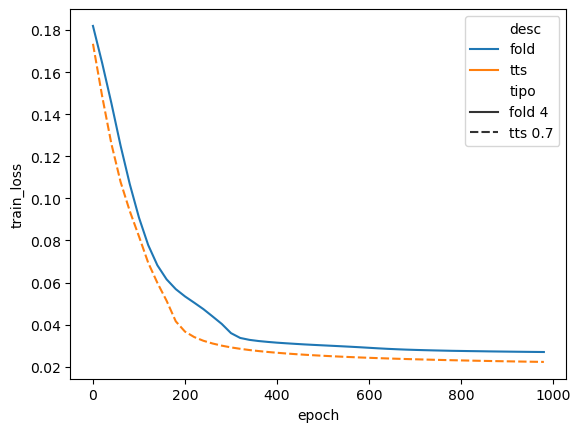

In [21]:
sns.lineplot(data=df[df.tipo.isin(["fold 4", "tts 0.7"])], 
             x="epoch", y="train_loss", hue="desc", style="tipo")
plt.show()

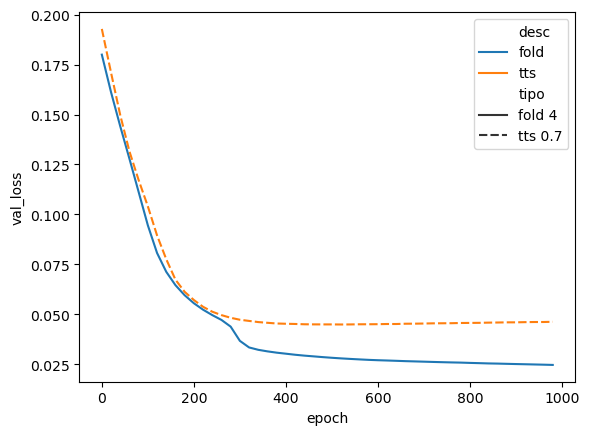

In [22]:
sns.lineplot(data=df[df.tipo.isin(["fold 4", "tts 0.7"])], 
             x="epoch", y="val_loss", hue="desc", style="tipo")
plt.show()

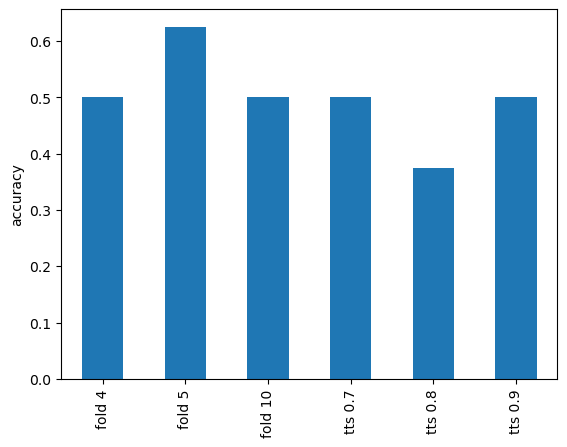

In [23]:
pd.Series(test_history).plot.bar()
plt.ylabel("accuracy")
plt.show()